In [2]:
import numpy as np
import tensorflow as tf

In [3]:
import torch

In [2]:
# ! pip install gym

In [3]:
from gym.spaces import Discrete
from gym.spaces import Tuple
from gym.spaces.box import Box

In [4]:
throttle_brake = Discrete(3)  # -1 brake, 0 keep, 1 throttle
steering = Discrete(3)
action_space = Tuple([throttle_brake,steering])

N = 4 # FIXME not hard code
F = 6 # FIXME not hard code
state_space = Box(low=-np.inf, high=np.inf, shape=(N,F), dtype=np.float32)

In [6]:
from tensorflow.keras.layers import Input, Dense, Lambda, Multiply, Reshape, Flatten, Masking, LSTM, Concatenate
from tensorflow.keras.models import Model



In [14]:
CAV_state_input = Input(name="cav_input",shape=(6,))
CAV_action_input = Input(name="cav_action",shape=(3,)) #throttle, brake, steering
input_concate = Concatenate(axis=-1)([CAV_state_input,CAV_action_input])
x = Dense(32,activation='relu',name="CAV_dynamics_1")(input_concate)
x = Dense(16,activation='relu',name="CAV_dynamics_2")(x)
out = Dense(6,activation=None)(x)
CAV_dynamics = Model(inputs=[CAV_state_input,CAV_action_input], outputs=out)
CAV_dynamics.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cav_input (InputLayer)          [(None, 6)]          0                                            
__________________________________________________________________________________________________
cav_action (InputLayer)         [(None, 3)]          0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 9)            0           cav_input[0][0]                  
                                                                 cav_action[0][0]                 
__________________________________________________________________________________________________
CAV_dynamics_1 (Dense)          (None, 32)           320         concatenate_7[0][0]        

In [17]:
HDV_state_input = Input(name="hdv_input",shape=(6,))
x = Dense(32,activation='relu',name="HDV_dynamics_1")(HDV_state_input)
x = Dense(16,activation='relu',name="HDV_dynamics_2")(x)
out = Dense(6,activation=None)(x)
HDV_dynamics = Model(inputs=HDV_state_input, outputs=out)
HDV_dynamics.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hdv_input (InputLayer)       [(None, 6)]               0         
_________________________________________________________________
HDV_dynamics_1 (Dense)       (None, 32)                224       
_________________________________________________________________
HDV_dynamics_2 (Dense)       (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 102       
Total params: 854
Trainable params: 854
Non-trainable params: 0
_________________________________________________________________


# Reverse the control commands

In [7]:
import glob
import pickle

In [10]:
!pwd

/Users/jiqiandong/Desktop/OneDrive - purdue.edu/work2/carla_rl


In [12]:
with open("./control_details/LHDV.p", 'rb') as f:
    commands = pickle.load(f)

In [16]:
commands_reversed = []
for command in commands:
    c = command.copy()
    c['steer'] = -command['steer']
    commands_reversed.append(c)

In [17]:
commands_reversed[50]

{'throttle': 0.0,
 'steer': -0.0,
 'brake': 0.0,
 'hand_brake': 0,
 'reverse': False,
 'manual_gear_shift': True,
 'gear': 0}

In [18]:
commands[50]

{'throttle': 0.0,
 'steer': 0.0,
 'brake': 0.0,
 'hand_brake': 0,
 'reverse': False,
 'manual_gear_shift': True,
 'gear': 0}

In [19]:
import random

In [31]:
random.choice([0,1])

0

In [32]:
with open("./control_details/LHDV_right.p", 'wb') as f:
    pickle.dump(commands_reversed,f)

In [4]:
b

array([[ 2,  4,  6],
       [ 8, 10, 12]])

In [7]:
np.mean([a,b],axis=0)

array([[1.5, 3. , 4.5],
       [6. , 7.5, 9. ]])

In [1]:
a = {'1':1,'b':2}

In [3]:
for key,val in a.items():
    print(key,val)

1 1
b 2


In [6]:
for item in a:
    print(a[item])

1
2


In [6]:
a = [[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]]]

In [7]:
a

[[[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]]]

In [10]:
import numpy as np
np.array(a)[-1,:,:]

array([[1, 2, 3],
       [4, 5, 6]])

## Test trajectory prediction module

In [2]:
import pickle
with open('./experience_data/Town03_data_pickle.pickle','rb') as f:
    d = pickle.load(f)

In [3]:
import torch
from collections import defaultdict

In [4]:
len(d)

15506

In [5]:
next(d.random_iterator(3,return_sequence=False,return_tensor=True))[2]['CAV'].shape

torch.Size([3, 6])

In [54]:

### load the model
from traj_pred_models import build_model
import matplotlib.pyplot as plt 

return_sequence = False
# model_type = 'linreg'
model_type = 'rnn'
# model_type = 'mlp'

seq_flag = 'seq' if return_sequence else 'nonseq'
cav_model_file = './models/Town03/{}_{}_{}.pt'.format('cav', model_type, seq_flag)
hdv_model_file = './models/Town03/{}_{}_{}.pt'.format('hdv', model_type, seq_flag)

cav_predictor, hdv_predictor, _, _ = build_model(model_type, return_sequence)

try:
    cav_predictor.load_state_dict(torch.load(cav_model_file))
    hdv_predictor.load_state_dict(torch.load(hdv_model_file))
    print("successfully loaded the %s model"%model_type)
except:
    print("no trained model found")

successfully loaded the rnn model


### CAV 

In [55]:
import numpy as np

In [56]:
state_batch, action_batch, next_state_batch = next(d.random_iterator(5,return_sequence=False,return_tensor=True))

cav_X = torch.cat([state_batch['CAV'],state_batch['current_control']],dim=-1)
outputs = cav_predictor.forward(cav_X).detach().numpy()

In [57]:
cs = outputs

In [58]:
ns = next_state_batch['CAV'].detach().numpy()

In [61]:
(np.sum((cs[:,:2] - ns[:,:2])**2,axis=1)**(0.5)).mean()

7.6802354

In [62]:
(np.sum((cs[:,2:4] - ns[:,2:4])**2,axis=1)**(0.5)).mean()

6.2554994

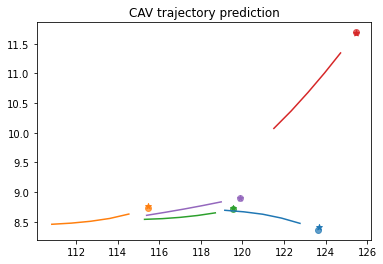

In [95]:
for i, (state,next_state) in enumerate(zip(state_batch['CAV'],next_state_batch['CAV'])):
    x = state[:,0]
    y = state[:,1]

    x_ = next_state[0]
    y_ = next_state[1]

    ax = plt.plot(x,y,label=str(i))
    plt.scatter(x_,y_,label='label_'+str(i),c=ax[0].get_color(),alpha=0.7)
    plt.scatter(outputs[i,0],outputs[i,1],label='predicted_'+str(i),marker='*',c=ax[0].get_color())
plt.title("CAV trajectory prediction")
# plt.legend()
# plt.show()
plt.savefig('./figures/cav_traj_pred.png',dpi=300)

### HDV

In [48]:
state_batch, action_batch, next_state_batch = next(d.random_iterator(2,return_sequence=False,return_tensor=True))

hdv_X = []
hdv_Y = []
for key in state_batch:
    if key!='CAV'and key!='current_control':
        hdv_X.append(state_batch[key])
        hdv_Y.append(next_state_batch[key])
hdv_X = torch.cat(hdv_X, dim=0) #(batch_size*num_vehicles, window_size, feature_size)
hdv_Y = torch.cat(hdv_Y, dim=0)
                    
outputs = hdv_predictor.forward(hdv_X).detach().numpy()

In [49]:
cs = outputs
ns = hdv_Y.detach().numpy()

In [50]:
cs.shape

(6, 6)

In [51]:
ns.shape

(6, 6)

In [52]:
np.sum((cs[:,:2] - ns[:,:2])**2,axis=1).mean()

0.46167326

In [53]:
np.sum((cs[:,2:4] - ns[:,2:4])**2,axis=1).mean()

0.03820369

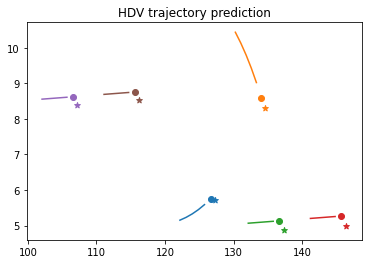

In [87]:
i = 0
for hdv_x, hdv_y,hdv_pred in zip(hdv_X,hdv_Y,outputs):
    i += 1
    x = hdv_x[:,0]
    y = hdv_x[:,1]
    x_ = hdv_y[0]
    y_ = hdv_y[1]
    ax = plt.plot(x,y,label=str(i))
    plt.scatter(x_,y_,label='label_'+str(i),c=ax[0].get_color())
    plt.scatter(hdv_pred[0],hdv_pred[1],label='predicted_'+str(i),marker='*',c=ax[0].get_color())

# plt.legend()
plt.title("HDV trajectory prediction")
# plt.show()
plt.savefig('./figures/hdv_traj_pred.png',dpi=300)

torch.Size([5, 5, 6])

In [ ]:


for i, (state,next_state) in enumerate(zip(state_batch['CAV'],next_state_batch['CAV'])):
    x = state[:,0]
    y = state[:,1]

    x_ = next_state[0]
    y_ = next_state[1]

    plt.plot(x,y,label=str(i))
    plt.scatter(x_,y_,label='label_'+str(i))
    plt.scatter(outputs[i,0],outputs[i,1],label='predicted_'+str(i),marker='*')

plt.legend()
plt.show()

## Load the model

In [65]:
### load the model
from traj_pred_models import build_model

return_sequence = False
model_type = 'linreg'

seq_flag = 'seq' if return_sequence else 'nonseq'
cav_model_file = './models/{}_{}_{}.pt'.format('cav', model_type, seq_flag)
hdv_model_file = './models/{}_{}_{}.pt'.format('hdv', model_type, seq_flag)

cav_predictor, hdv_predictor, _, _ = build_model(model_type, return_sequence)

try:
    cav_predictor.load_state_dict(torch.load(cav_model_file))
    hdv_predictor.load_state_dict(torch.load(hdv_model_file))
    print("successfully loaded the %s model"%model_type)
except:
    print("no trained model found")

successfully loaded the linreg model


In [66]:
cav_state = torch.tensor(current_state['CAV']).float()
cav_control = torch.tensor(current_state['current_control']).float()
cav_X = torch.cat([cav_state,cav_control],dim=-1)   

cav_X = torch.stack([cav_X]*10)
cav_X.shape

NameError: name 'current_state' is not defined

In [16]:
hdv_X = torch.tensor([current_state[key] for key in current_state if key!='CAV'and key!='current_control']).float()
hdv_X.shape

torch.Size([3, 5, 6])

In [17]:
cav_predictor.eval()
hdv_predictor.eval()

LinearRegression(
  (output_layer): Linear(in_features=30, out_features=6, bias=True)
)

In [18]:
cav_output = cav_predictor.forward(cav_X).detach()
hdv_output = hdv_predictor.forward(hdv_X).detach()

In [19]:
cav_output.shape, hdv_output.shape

(torch.Size([10, 6]), torch.Size([3, 6]))

In [20]:
cav_output

tensor([[1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01],
        [1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01]])

In [21]:
hdv_output

tensor([[ 1.1396e+02,  1.1917e+01,  1.8350e+01,  8.7175e-02, -5.9909e-01,
         -4.4729e-01],
        [ 1.2388e+02,  4.9447e+00,  1.8370e+01,  1.2355e-01, -5.6857e-01,
          5.3567e-01],
        [ 1.0363e+02,  8.4830e+00,  2.0129e+01,  1.6795e-01, -5.4159e-01,
          4.6033e-01]])

In [29]:
from sklearn.metrics import pairwise_distances

dist_matrix = pairwise_distances(cav_output.numpy()[:,:2],hdv_output.numpy()[:,:2])

In [30]:
dist_matrix

array([[ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ],
       [ 5.0497937, 14.074173 ,  6.627503 ]], dtype=float32)

In [33]:
threshold = 6
cost = (dist_matrix<threshold).sum(axis=1)
cost

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
import numpy as np
np.sqrt((1.1026e+02 - 1.2388e+02)**2 + (8.4799e+00-4.9447e+00)**2)

14.07131973341519

In [38]:
hdv_X_new = torch.stack([torch.cat([val[1:,:],new_val.unsqueeze(0)],dim=0) for val,new_val in zip(hdv_X,hdv_output)]).float()
hdv_X_new.shape
# hdv_X_new

torch.Size([3, 5, 6])

In [74]:
current_controls = torch.stack([torch.tensor(current_control)]*10)
current_controls.shape

torch.Size([10, 3])

In [77]:
cav_new_state = torch.cat([cav_output,current_controls],dim=1).unsqueeze(1)
cav_new_state.shape

torch.Size([10, 1, 9])

In [78]:
cav_X_new = torch.cat([cav_X[:,1:,:],cav_new_state],dim=1)
cav_X_new.shape

torch.Size([10, 5, 9])

In [61]:
new_state

tensor([[[1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02,
          8.4095e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00]]])

In [62]:
cav_X_new

tensor([[[ 1.0713e+02,  8.4289e+00,  1.8748e+01,  2.9832e-01, -3.4691e-01,
          -5.5498e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0807e+02,  8.4438e+00,  1.8731e+01,  2.9805e-01, -3.4653e-01,
          -5.5295e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0900e+02,  8.4587e+00,  1.8714e+01,  2.9777e-01, -3.4607e-01,
          -5.5146e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0994e+02,  8.4736e+00,  1.8697e+01,  2.9750e-01, -3.4576e-01,
          -5.5015e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.1026e+02,  8.4799e+00,  1.8548e+01,  2.9652e-01,  9.4593e-02,
           8.4095e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00]]])

In [63]:
cav_X

tensor([[[ 1.0619e+02,  8.4140e+00,  1.8766e+01,  2.9860e-01, -3.4733e-01,
          -5.5754e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0713e+02,  8.4289e+00,  1.8748e+01,  2.9832e-01, -3.4691e-01,
          -5.5498e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0807e+02,  8.4438e+00,  1.8731e+01,  2.9805e-01, -3.4653e-01,
          -5.5295e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0900e+02,  8.4587e+00,  1.8714e+01,  2.9777e-01, -3.4607e-01,
          -5.5146e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0994e+02,  8.4736e+00,  1.8697e+01,  2.9750e-01, -3.4576e-01,
          -5.5015e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00]]])

In [64]:
cav_output

tensor([[1.1026e+02, 8.4799e+00, 1.8548e+01, 2.9652e-01, 9.4593e-02, 8.4095e-01]])

In [1]:
cav_output

NameError: name 'cav_output' is not defined

In [38]:
d._state_history.keys()

dict_keys(['CAV', 'LHDV', 'FHDV', 'BHDV', 'current_control'])

# 

## Test the ttc computing

In [1]:
import numpy as np


In [2]:
cav_output = np.repeat(np.array([1,2,3]).reshape(-1,1),repeats=6,axis=1)
cav_output

array([[1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3]])

In [3]:
hdv_output = np.repeat(np.array([10,20,30,40]).reshape(-1,1),repeats=6,axis=1)
hdv_output

array([[10, 10, 10, 10, 10, 10],
       [20, 20, 20, 20, 20, 20],
       [30, 30, 30, 30, 30, 30],
       [40, 40, 40, 40, 40, 40]])

In [4]:
vecs = np.array([cav[:] - hdv_output for cav in cav_output])
vecs.shape # num_traj, num_hdv, vec
vecs

array([[[ -9,  -9,  -9,  -9,  -9,  -9],
        [-19, -19, -19, -19, -19, -19],
        [-29, -29, -29, -29, -29, -29],
        [-39, -39, -39, -39, -39, -39]],

       [[ -8,  -8,  -8,  -8,  -8,  -8],
        [-18, -18, -18, -18, -18, -18],
        [-28, -28, -28, -28, -28, -28],
        [-38, -38, -38, -38, -38, -38]],

       [[ -7,  -7,  -7,  -7,  -7,  -7],
        [-17, -17, -17, -17, -17, -17],
        [-27, -27, -27, -27, -27, -27],
        [-37, -37, -37, -37, -37, -37]]])

In [5]:
import torch

In [6]:
hdv_output = torch.tensor(hdv_output).float().detach()
cav_output = torch.tensor(cav_output).float().detach()
hdv_output.shape, cav_output.shape

(torch.Size([4, 6]), torch.Size([3, 6]))

In [10]:
# n_traj, n_hdv,_ = diff.shape
# diff

tensor([[[ -9.,  -9.,  -9.,  -9.],
         [-19., -19., -19., -19.],
         [-29., -29., -29., -29.],
         [-39., -39., -39., -39.]],

        [[ -8.,  -8.,  -8.,  -8.],
         [-18., -18., -18., -18.],
         [-28., -28., -28., -28.],
         [-38., -38., -38., -38.]],

        [[ -7.,  -7.,  -7.,  -7.],
         [-17., -17., -17., -17.],
         [-27., -27., -27., -27.],
         [-37., -37., -37., -37.]]])

In [4]:
def TTC_batch_computing(cav_output, hdv_output, safety_distance):

    diff = cav_output[:,:4].unsqueeze(1) - hdv_output[:,:4].unsqueeze(0) # [n_traj, n_hdv, 4] (x,y,vx,vy)

    x_diff = diff[:,:,:2] # [n_traj, n_hdv, 2]
    v_diff = diff[:,:,2:] # [n_traj, n_hdv, 2]

    dist = torch.norm(x_diff,p=2,dim=-1) #[n_traj, n_hdv]
    projection = torch.bmm(v_diff.view(-1,1,2),x_diff.view(-1,2,1)).view(n_traj,n_hdv)
    projection = torch.true_divide(projection,dist)
    ttc = torch.true_divide(dist-safety_distance,projection) # [n_traj, n_hdv]

    return ttc 

toy_cav_output = torch.tensor(np.repeat(np.array([1,2,3]).reshape(-1,1),repeats=6,axis=1),requires_grad=False).float()
toy_hdv_output = torch.tensor(np.repeat(np.array([10,20,30,40]).reshape(-1,1),repeats=6,axis=1),requires_grad=False).float()

TTC_batch_computing(toy_cav_output,toy_hdv_output,safety_distance=0)

NameError: name 'n_traj' is not defined

In [20]:
diff+1

tensor([[[ -8.,  -8.,  -8.,  -8.],
         [-18., -18., -18., -18.],
         [-28., -28., -28., -28.],
         [-38., -38., -38., -38.]],

        [[ -7.,  -7.,  -7.,  -7.],
         [-17., -17., -17., -17.],
         [-27., -27., -27., -27.],
         [-37., -37., -37., -37.]],

        [[ -6.,  -6.,  -6.,  -6.],
         [-16., -16., -16., -16.],
         [-26., -26., -26., -26.],
         [-36., -36., -36., -36.]]])

In [14]:
torch.norm(x_diff,p=2,dim=-1)

tensor([[12.7279, 26.8701, 41.0122, 55.1543],
        [11.3137, 25.4558, 39.5980, 53.7401],
        [ 9.8995, 24.0416, 38.1838, 52.3259]])

In [15]:
np.sqrt(9**2*2)

12.727922061357855

### Numpy

In [98]:
diff = np.expand_dims(cav_output[:,:4],axis=1) - np.expand_dims(hdv_output[:,:4],axis=0)
diff

array([[[ -9,  -9,  -9,  -9],
        [-19, -19, -19, -19],
        [-29, -29, -29, -29],
        [-39, -39, -39, -39]],

       [[ -8,  -8,  -8,  -8],
        [-18, -18, -18, -18],
        [-28, -28, -28, -28],
        [-38, -38, -38, -38]],

       [[ -7,  -7,  -7,  -7],
        [-17, -17, -17, -17],
        [-27, -27, -27, -27],
        [-37, -37, -37, -37]]])

In [121]:
np.tensordot(diff[:,:,:2],diff[:,:,2:],axes=([2],[2])).shape

(3, 4, 3, 4)

In [117]:
n_traj, n_hdv,_ = diff.shape

In [ ]:
diff[:,:,:2]

In [119]:
diff[:,:,:2].reshape(n_traj,-1).shape

(3, 8)

In [ ]:
diff[:,:,2:].reshape(n_traj,-1)

In [108]:
def TTC_batch_computing(cav_output, hdv_output, safety_distance):
    # cav_output.shape = [num_trj, feature_size=6]
    # hdv_output.shape = [num_hdvs, feature_size=6] 
    ### TTC function 
    #{||delta_d|| - safety_distance}/{(-delta_v.dot(delta_d)) / ||delta_d||}

    diff = cav_output[:,:4].unsqueeze(1) - hdv_output[:,:4].unsqueeze(0) # [n_traj, n_hdv, 4] (x,y,vx,vy)

    n_traj, n_hdv, _ = diff.shape

    x_diff = diff[:,:,:2] # [n_traj, n_hdv, 2]
    v_diff = diff[:,:,2:] # [n_traj, n_hdv, 2]

    dist = torch.norm(x_diff,p=2,dim=-1) #[n_traj, n_hdv]
    projection = torch.bmm(v_diff.view(-1,1,2),x_diff.view(-1,2,1)).view(n_traj,n_hdv)
    projection = torch.div(-projection,dist)

    valid_distance = dist - safety_distance
    valid_distance[valid_distance<0] = 1e-4 # already below safety distance

    ttc = torch.div(valid_distance,projection) # [n_traj, n_hdv]

    ttc[ttc<0] = float('inf')

    return ttc

cav_out_toy = torch.tensor([[0,0,1,2,9,9],[0,0,2,0,9,9]]).view([-1,6]).float()
hdv_out_toy = torch.tensor([[2,2,-1,-1,8,8],[2,0,-1,0,8,8],[2,0,3,0,8,8]]).view([-1,6]).float()

TTC_batch_computing(cav_out_toy,hdv_out_toy,0)

tensor([[0.8000, 1.0000,    inf],
        [1.0000, 0.6667,    inf]])

In [8]:
toy_cav_output = torch.tensor(,requires_grad=False).float()
toy_hdv_output = torch.tensor(np.repeat(np.array([10,20,30,40]).reshape(-1,1),repeats=6,axis=1),requires_grad=False).float()
TTC_batch_computing(toy_cav_output,toy_hdv_output,safety_distance=0)

IndexError: too many indices for tensor of dimension 1

In [13]:
np.repeat(np.array([1,2,3]).reshape(1,-1),repeats=6,axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

## Draft gradient based optimization

In [23]:
t = torch.randn([2,3])
t

tensor([[-0.1503,  0.0911, -0.9458],
        [-0.1827,  0.2082, -1.5733]])

In [24]:
torch.softmax(t, dim=1)

tensor([[0.3670, 0.4673, 0.1657],
        [0.3667, 0.5420, 0.0913]])

In [67]:
from traj_pred_models import build_model
return_sequence = False
model_type = 'linreg'
seq_flag = 'seq' if return_sequence else 'nonseq'
cav_model_file = './models/{}_{}_{}.pt'.format('cav', model_type, seq_flag)
hdv_model_file = './models/{}_{}_{}.pt'.format('hdv', model_type, seq_flag)

cav_predictor, hdv_predictor, _, _ = build_model(model_type, return_sequence)

print(cav_model_file,hdv_model_file)

try:
    cav_predictor.load_state_dict(torch.load(cav_model_file))
    hdv_predictor.load_state_dict(torch.load(hdv_model_file))

    cav_predictor.eval()
    hdv_predictor.eval()

    print("successfully loaded the %s model"%model_type)
except:
    pass

./models/cav_linreg_nonseq.pt ./models/hdv_linreg_nonseq.pt
successfully loaded the linreg model


In [68]:
import pickle
with open('./experience_data/data_pickle.pickle','rb') as f:
    d = pickle.load(f)

In [70]:
state_batch, action_batch, next_state_batch = next(d.random_iterator(10,return_sequence=False,return_tensor=True))

cav_X = torch.cat([state_batch['CAV'],state_batch['current_control']],dim=-1)
outputs = cav_predictor.forward(cav_X)
hdv_X = torch.cat([state_batch[key] for key in state_batch if key!='CAV'and key!='current_control'],dim=0)

cav_X.shape,hdv_X.shape

(torch.Size([10, 5, 9]), torch.Size([30, 5, 6]))

In [72]:
current_controls = cav_X[:,-1,-3:]

tensor([[ 1.0000e+00,  2.0000e-01,  0.0000e+00],
        [ 0.0000e+00,  2.0000e-01,  0.0000e+00],
        [ 0.0000e+00, -8.0000e-01,  0.0000e+00],
        [ 0.0000e+00,  1.0000e-01,  0.0000e+00],
        [ 1.0000e+00, -1.1000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.7756e-17,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  1.0000e-01,  0.0000e+00],
        [ 0.0000e+00,  1.0000e-01,  1.0000e+00]])

In [80]:
import numpy as np
random_actions = np.random.choice(3,size=[20,10,2]) #[horizon, num_traj, 2]
def process_action(action, current_control):
    # this function is the same as in the controller module
    dec = action.copy()
    dec -= 1
    if dec[0]==-1:
        throttle = 0
        brake = 1
    elif dec[0] == 0:
        throttle = 0
        brake = 0
    elif dec[0]==1:
        throttle = 1
        brake = 0
    else:
        print(dec)
        raise Exception("no specific throttle brake control command")

    steer = current_control[1] + dec[1]*0.1
    return [throttle, steer, brake]

new_control  = torch.tensor([process_action(a,c) for a,c in zip(random_actions[0],current_controls)]).float()

In [83]:
current_controls


tensor([[ 1.0000e+00,  2.0000e-01,  0.0000e+00],
        [ 0.0000e+00,  2.0000e-01,  0.0000e+00],
        [ 0.0000e+00, -8.0000e-01,  0.0000e+00],
        [ 0.0000e+00,  1.0000e-01,  0.0000e+00],
        [ 1.0000e+00, -1.1000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.7756e-17,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  1.0000e-01,  0.0000e+00],
        [ 0.0000e+00,  1.0000e-01,  1.0000e+00]])

In [82]:
random_actions[0]

array([[2, 2],
       [2, 0],
       [0, 0],
       [0, 2],
       [2, 1],
       [2, 0],
       [2, 1],
       [2, 2],
       [0, 2],
       [2, 0]])

In [81]:
new_control

tensor([[ 1.0000e+00,  3.0000e-01,  0.0000e+00],
        [ 1.0000e+00,  1.0000e-01,  0.0000e+00],
        [ 0.0000e+00, -9.0000e-01,  1.0000e+00],
        [ 0.0000e+00,  2.0000e-01,  1.0000e+00],
        [ 1.0000e+00, -1.1000e+00,  0.0000e+00],
        [ 1.0000e+00, -1.0000e-01,  0.0000e+00],
        [ 1.0000e+00,  2.7756e-17,  0.0000e+00],
        [ 1.0000e+00,  1.0000e-01,  0.0000e+00],
        [ 0.0000e+00,  2.0000e-01,  1.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00]])

In [64]:
init = torch.randn([2,3])
init

tensor([[ 0.5462,  0.1896, -0.2812],
        [ 0.0329,  0.5518, -0.1629]])

In [84]:
a = np.arange(9).reshape(3,3)
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [88]:
np.where(a<5,a,0)

array([[0, 1, 2],
       [3, 4, 0],
       [0, 0, 0]])

## Plot results

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

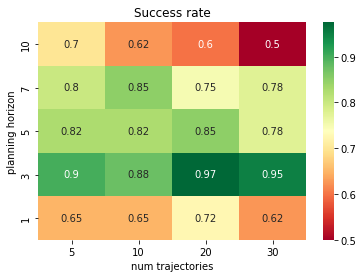

In [68]:
def heatmap_plot(data_f):
    data = pd.read_csv(data_f,delimiter=' ', header=None)
    data.columns = ['planning horizon','num trajectories','success rate']
    new = pd.pivot_table(data,columns='num trajectories',index='planning horizon',values='success rate')
    ax = sns.heatmap(new,annot=True,cmap='RdYlGn')
    ax.invert_yaxis()
    plt.title("Success rate")
heatmap_plot('./result20.txt')
# plt.savefig('./figures/20speed.png',dpi=300)

In [69]:
heatmap_plot('./result15.txt')
# plt.savefig('./figures/15speed.png',dpi=300)

/tmp/ipykernel_10997/845958617.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  new = pd.pivot_table(data,columns='num trajectories',index='planning horizon',values='success rate')


ValueError: zero-size array to reduction operation fmin which has no identity

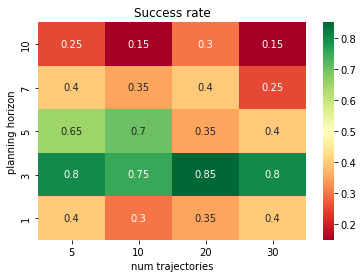

In [70]:
heatmap_plot('./25new.txt')
# plt.savefig('./figures/25speed_new.png',dpi=300)

## Test human

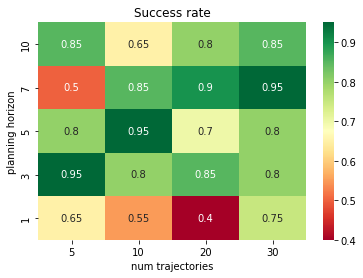

In [71]:
heatmap_plot('./result20_human.txt')

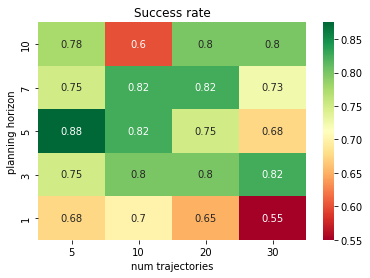

In [72]:
heatmap_plot('./result25_human.txt')

In [74]:
heatmap_plot('./result15.txt')

/tmp/ipykernel_10997/845958617.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  new = pd.pivot_table(data,columns='num trajectories',index='planning horizon',values='success rate')


ValueError: zero-size array to reduction operation fmin which has no identity

In [3]:
!python -m pip install pyyaml

   ---------------------------------------- 153.2/153.2 kB 4.6 MB/s eta 0:00:00


In [16]:
import yaml

In [17]:
with open("./cfg.yaml", 'r') as f:
    params = yaml.safe_load(f)

In [18]:
params["init_params"]

{'cav_loc': 1,
 'speed': 20,
 'bhdv_init_speed': 10,
 'headway': 10,
 'loc_diff': 4.5,
 'headway_2': 7,
 'warming_up_steps': 50}

In [15]:
params

{'init_params': {'cav_loc': 1,
  'speed': 20,
  'bhdv_init_speed': 10,
  'headway': 10,
  'loc_diff': 4.5,
  'headway_2': 7},
 'env_params': {'city_name': 'Town03', 'lhdv_controlle_type': 'human'},
 'crash_avoid_params': {'planning_horizon': 5,
  'num_trajectories': 5,
  'CEM_iters': 10},
 'sim_params': {'mode': 'eval',
  'max_steps_per_episode': 100,
  'ip': '127.0.0.1',
  'port': 2000,
  'render': True,
  'num_runs': 20,
  'saving_data': False}}